In [1]:
from __future__ import division
import gym
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter

from keras.models import model_from_json

%matplotlib inline

Using TensorFlow backend.


In [2]:
from gridworld import gameEnv, gameOb

## Loading the model

In [164]:
path = "./models" # Path to save our model to
main_weights_file = path + "/main_weights.h5" # File to save our main weights to

with open("model_keras.json", "r") as model_json:
    model = model_from_json(model_json.read()) # Load the model architecture from JSON

model.load_weights(main_weights_file) # Load the weights

## Helpers

In [238]:
def create_env(objects):
    """ Create an env object based on objects provided
        
        0 is Blank (blank space to move)
        1 is Fire (red, avoid)
        2 is Hero (blue, control)
        3 is Goal (green, try to capture)
        
        Length of objects must be a square and there must be one hero
        
        e.g. create_env([1,0,0,
                         0,2,0,
                         0,0,3]
    """
    size = len(objects) ** 0.5
    assert (size % 1 == 0), "Grid must be square" 
    assert Counter(objects).get(2) == 1, "Must be only one hero"
    assert (set(objects).difference({0,1,2,3}) == set()), "Only contains 0,1,2,3"
    params = {
        1: lambda pos: gameOb(pos,1,1,0,-1,"fire"),
        2: lambda pos: gameOb(pos,1,1,2,None,"hero"),
        3: lambda pos: gameOb(pos,1,1,1,1,"goal"),  
    }
    
    env = gameEnv(partial=False,size=int(size))
    updated_objects = []
    for idx, o in enumerate(objects):
        if o not in params:
            continue

        x = int(idx % size)
        y = int(idx // size)
        
        ob = params[o]((x,y))
        if o == 2:
            updated_objects = [ob] + updated_objects
        else:
            updated_objects.append(ob)
        
    env.objects = updated_objects
    env.state = env.renderEnv()
    
    return env

def pretty_predict(predict):
    """ Returns string output of a neural network used in gridworld to human readable instructions
        0: up, 1: down, 2: left, 3: right 
        e.g.
            pretty_predict(model.predict(state))
            out:
               ⇧        ⇩       ⇦       ⇨    
             0.704    2.263    1.680    1.670 
        """
    
    
    if len(predict.shape) > 1:
        return pretty_predict(predict[0])
    
    out = "    ⇧        ⇩        ⇦         ⇨    \n {:0.3f}    {:0.3f}    {:0.3f}    {:0.3f}  ".format(*predict)
    return out

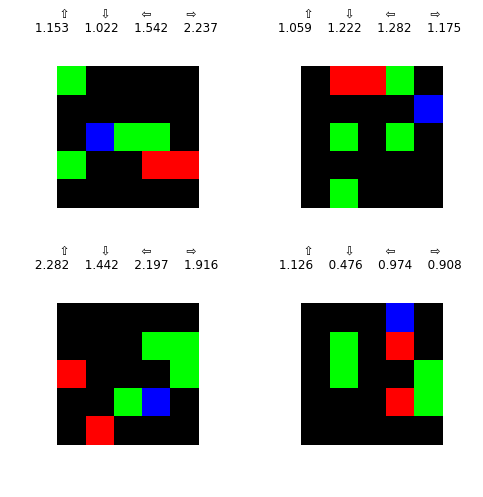

In [229]:
max_num_step = 4

f, axes = plt.subplots(nrows=max_num_step//2, ncols=2, 
                       sharex=True, sharey=True, figsize=(8,8))

env = gameEnv(partial=False, size=5)

for ax in axes.ravel():
    state = env.reset()
    state = np.expand_dims(state,axis=0)
    out = model.predict(state)
    title = pretty_predict(out)
    ax.imshow(state[0])
    ax.set_title(title)
    ax.set_axis_off()


## Custom maps

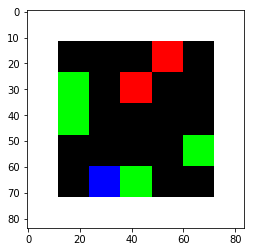

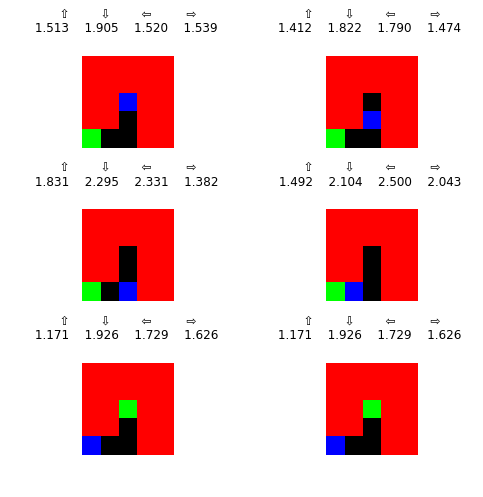

In [241]:
env = create_env([1,1,1,1,1,
                  1,1,1,1,1,
                  1,1,2,1,1,
                  1,1,0,1,1,
                  3,0,0,1,1]) # Custom map that has one possible path to goal without incurring penalty

max_num_step = 6

f, axes = plt.subplots(nrows=max_num_step//2, ncols=2, 
                       sharex=True, sharey=True, figsize=(8,8))

state = env.state

for ax in axes.ravel():
    out = model.predict(np.expand_dims(state,0))
    title = pretty_predict(out)
    ax.imshow(state)
    ax.set_title(title)
    ax.set_axis_off()
    action = np.argmax(out,axis=1)[0]
    state, reward, done = env.step(action)
